<h3> Project Title: 
The Battle of Neighborhoods,
segmenting and clustering

<h3> 1) Introduction and Business Problem </h3>

<h3> A description of the problem and a discussion of the background </h3>


The purpose of this Project is to help people in exploring better facilities around their neighborhood. It will help people making smart and efficient decision on selecting great neighborhood out of numbers of other neighborhoods in York, Toronto.

It will help people to get awareness of the area and neighborhood before moving to a new city, state, country or place for their work or to start a new fresh life.

Lots of people are migrating to various states of Canada and needed lots of research for good housing prices and reputated schools for their children. This project is for those people who are looking for better neighborhoods. Best schools in the neighborhoods, cafe, super market, medical shops, grocery shops, mall, theatre, hospital etc.

This Project aims to create an analysis of features for a people migrating to York to search a best neighborhood as a comparative analysis between neighborhoods. The features include better school according to ratings and etc.

<h3> 2) Data Description</h3>
<h3> A description of the data and how it will be used to solve the problem </h3>

We will be using Toronto dataset which we scrapped from wikipedia on Week 3. Dataset consisting of latitude and longitude, zip codes. 
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

The dataset will consist of three columns: PostalCode, Borough, and Neighborhood Only process the cells that have an assigned borough. 

To get the latitude and the longitude coordinates of each neighborhood, we will use a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data to get the latitude and the longitude coordinates of each neighborhood. For schools rating https://www.greatschools.org

We will be using the Foursquare API to explore neighborhoods in York, Toronto. Also, will use explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. To clustering we will use the k-means clustering algorithm to complete this task. Finally, we will use the Folium library to visualize the neighborhoods in York and their emerging clusters.

<h3> 3) Methodology </h3>

Clustering Approach: To find similar neighborhoods we explore and cluster neighborhoods, segment them, and group them into 5 clusters, and we used k-means clustering algorithm.

<h3> 4) Results </h3>

As a result, York is one of the most diverse and multicultural areas in the Greater Toronto Area. 
We used Foursquare API to get neighborhoods, values. As a result we found out that 1) Park 2) West 3) North South were the most prefered neighborhoods.
The best rating schools were in in the following neighborhoods:
    Glencairn	
	Lawrence Park	
	Dorset Park,Scarborough Town Centre 	
	Cliffcrest,Cliffside,Scarborough Village West
    
<h3> 5) Discussion </h3>

We tried to solve the following two main problems:
1) Sorted list of best neighborhoods
2) Sorted list of schools in terms of rating and reviews    

<h3> 6) Conclusion </h3>

In this project, using k-means cluster algorithm we separated the neighborhood into five different clusters and for 103 different lattitude and logitude from dataset, analyzed neighborhoods in York city. 


In [1]:
# load and install all the neccessary packages 

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge wordcloud==1.4.1 --yes
from wordcloud import WordCloud, STOPWORDS

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')


Bad key "echo "backend" on line 2 in
/Users/nilu/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


Solving environment: done

# All requested packages already installed.

Libraries imported.



Download the from from wikipedia as html,
use BeautifySoup to parse html data, and create a dataframe

In [2]:
# get html from wiki page and create soup object
wiki_postal_codes = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(wiki_postal_codes.text, 'html.parser')

In [3]:
postalCodeList = []
boroughList = []
neighborhoodList = []

for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text)
        boroughList.append(cells[1].text)
        neighborhoodList.append(cells[2].text.rstrip('\n')) # remove the new line char from neighborhood cell

toronto_neighorhood = {'PostalCode':postalCodeList,'Borough':boroughList,'Neighborhood': neighborhoodList}
toronto_df = pd.DataFrame.from_dict(toronto_neighorhood)
toronto_df.head()        
        

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [44]:
# Remove Boroughs that are 'Not assigned'
toronto_df = toronto_df[toronto_df['Borough'] != 'Not assigned'].reset_index(drop=True)
print(toronto_df.shape)
toronto_df.head()

(103, 3)


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

In [5]:
toronto_df = toronto_df.groupby(['PostalCode','Borough'], as_index=False).agg(lambda x: ','.join(x))
toronto_df = toronto_df.drop_duplicates() 
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [6]:
na_neigh_rows = toronto_df.Neighborhood == 'Not assigned'
toronto_df.loc[na_neigh_rows, 'Neighborhood'] = toronto_df.loc[na_neigh_rows, 'Borough']
toronto_df[na_neigh_rows]

,PostalCode,Borough,Neighborhood
93,M9A,Queen's Park,Queen's Park


In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [7]:
toronto_df.shape

(103, 3)


Add Geospatial Data
Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

We will use a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data to get the latitude and the longitude coordinates of each neighborhood.

In [8]:
# download coordinated data as csv file
!wget -q -O 'coordinates.csv' http://cocl.us/Geospatial_data
print('Data downloaded!')

Data downloaded!


In [9]:
# read coordinates 
coords = pd.read_csv('coordinates.csv')
coords.head()
# note that the "Postal Code" column name is different

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
toronto_df.shape

(103, 3)

In [11]:
coords.shape

(103, 3)

In [12]:
# merge two dataframes
toronto_df_temp = toronto_df.set_index('PostalCode')
coors_temp = coords.set_index('Postal Code')
toronto_df_coors = pd.concat([toronto_df_temp, coors_temp], axis=1, join='inner')
toronto_df_coors.index.name = 'PostalCode'
toronto_df_coors.reset_index(inplace=True)

In [13]:
print(toronto_df_coors.shape)
toronto_df_coors.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<h3> Get the locations </h3>


In [14]:
# get the latitude and longitude for Toronto
address = 'Toronto, York'

geolocator = Nominatim(user_agent="tl-toronto-neigh")
location = geolocator.geocode(address, timeout=10)
latitude = location.latitude
longitude = location.longitude
print(f"The geograpical coordinates of York, Toronto are {latitude}, {longitude}")


The geograpical coordinates of York, Toronto are 43.67910515, -79.49118414007154


In [15]:
# Show an initial map of the neighborhoods in Etobicoke Toronto
# Create map of Toronto using first entries latitude and longitude values

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, long, post, borough, neigh in zip(toronto_df_coors['Latitude'], toronto_df_coors['Longitude'], toronto_df_coors['PostalCode'], toronto_df_coors['Borough'], toronto_df_coors['Neighborhood']):
    label = f"{borough} ({post}): {neigh}"
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=7,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto

In [16]:
# Filter Toronto data to only use boroughs 
toronto_boroughs = ['Central Toronto', 'Downtown Toronto']

toronto_central_df = toronto_df_coors[toronto_df_coors['Borough'].isin(toronto_boroughs)].reset_index(drop=True)
print(toronto_central_df.shape)
toronto_central_df.head()

(28, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160


In [17]:
# Generate a map of neighborhoods in Toronto using first entries latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, long, post, borough, neigh in zip(toronto_central_df['Latitude'], toronto_central_df['Longitude'], toronto_central_df['PostalCode'], toronto_central_df['Borough'], toronto_central_df['Neighborhood']):
    label = "{} ({}): {}".format(borough, post, neigh)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

Use Four Square API to explore the neighborhoods and segment them

In [18]:
# set up Four Square API credentials
CLIENT_ID = 'S23HIN0H3VIHZHSIJ5KDFG3XWYUKXZFXLD3SWBYU1ICN0RZZ' # your Foursquare ID
CLIENT_SECRET = 'EZS2RSTPDBMZSRIDBLKTJRGO5E5VXLYBZOXTWL4JLOI35BWA' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: S23HIN0H3VIHZHSIJ5KDFG3XWYUKXZFXLD3SWBYU1ICN0RZZ
CLIENT_SECRET:EZS2RSTPDBMZSRIDBLKTJRGO5E5VXLYBZOXTWL4JLOI35BWA


In [19]:
# Setup API URL to explore venues near by
radius = 500
LIMIT = 100
venues = []

for lat, long, post, borough, neighborhood in zip(toronto_central_df['Latitude'], toronto_central_df['Longitude'], toronto_central_df['PostalCode'], toronto_central_df['Borough'], toronto_central_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))


In [20]:
# create vanues dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
print(venues_df.shape)
venues_df.head()

(1427, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Booty Camp Fitness,43.728051,-79.387853,Gym / Fitness Center
2,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
3,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
4,M4P,Central Toronto,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop


In [21]:
# count values names 
venues_df.groupby(['PostalCode', 'Borough', 'Neighborhood'])['VenueName'].count()

PostalCode  Borough           Neighborhood                                                                                        
M4N         Central Toronto   Lawrence Park                                                                                             4
M4P         Central Toronto   Davisville North                                                                                          8
M4R         Central Toronto   North Toronto West                                                                                       24
M4S         Central Toronto   Davisville                                                                                               34
M4T         Central Toronto   Moore Park,Summerhill East                                                                                3
M4V         Central Toronto   Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West                                            15
M4W         Downtown Toronto  Rosedale   

In [22]:
# return unique values category
venues_df['VenueCategory'].nunique()

217

In [23]:
# one hot encoding
toronto_central_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
toronto_central_onehot['PostalCode'] = venues_df['PostalCode'] 
toronto_central_onehot['Borough'] = venues_df['Borough'] 
toronto_central_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_central_onehot.columns[-3:]) + list(toronto_central_onehot.columns[:-3])
toronto_central_onehot = toronto_central_onehot[fixed_columns]

print(toronto_central_onehot.shape)
toronto_central_onehot.head()

(1427, 220)


,PostalCode,Borough,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,M4N,Central Toronto,Lawrence Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M4N,Central Toronto,Lawrence Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [24]:
toronto_central_venues_freq = toronto_central_onehot.groupby(['PostalCode', 'Borough', 'Neighborhoods']).mean().reset_index()
print(toronto_central_venues_freq.shape)
toronto_central_venues_freq.head()

(28, 220)


,PostalCode,Borough,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,M4N,Central Toronto,Lawrence Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.000000,0.0,0.0,0.000000,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000

In [25]:
# set top 10 vanues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_central_venues_freq['PostalCode']
neighborhoods_venues_sorted['Borough'] = toronto_central_venues_freq['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_central_venues_freq['Neighborhoods']

for ind in np.arange(toronto_central_venues_freq.shape[0]):
    row_categories = toronto_central_venues_freq.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
neighborhoods_venues_sorted.head()

,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,M5V,Downtown Toronto,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Service,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Bar,Coffee Shop,Plane,Sculpture Garden
11,M5C,Downtown Toronto,St. James Town,Café,Coffee Shop,Restaurant,Breakfast Spot,Bakery,Beer Bar,Clothing Store,Cocktail Bar,Diner,Hotel
21,M5S,Downtown Toronto,"Harbord,University of Toronto",Café,Restaurant,Sandwich Place,Bookstore,Japanese Restaurant,Italian Restaurant,Bar,Bakery,French Restaurant,Pub
22,M5T,Downtown Toronto,"Chinatown,Grange Park,Kensington Market",Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Chinese Restaurant,Dumpling Restaurant,Mexican Restaurant,Bakery,Bar,Grocery Store
1,M4P,Central Toronto,Davisville North,Clothing Store,Food & Drink Shop,Gym,Park,Breakfast Spot,Sandwich Place,Dance Studio,Hotel,Donut Shop,Dumpling Restaurant


<h3> KMeans Clustering </h3>

Use KMeans algorigthm, cluster the toronto central areas into 5 classes

In [47]:
# set number of clusters
kclusters = 5
toronto_central_venues_freq_clustering = toronto_central_venues_freq.drop(['PostalCode', 'Borough', 'Neighborhoods'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_central_venues_freq_clustering)

# add clustering labels
toronto_central_clustered_df = toronto_central_df
toronto_central_clustered_df['Cluster'] = kmeans.labels_

toronto_central_clustered_df = toronto_central_clustered_df.join(neighborhoods_venues_sorted.drop(['Borough', 'Neighborhoods'], 1).set_index('PostalCode'), on='PostalCode')
toronto_central_clustered_df.sort_values(['Cluster'] + freqColumns, inplace=True)
toronto_central_clustered_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Gym / Fitness Center,Swim School,Bus Line,Park,Greek Restaurant,Diner,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant
19,M5P,Central Toronto,"Forest Hill North,Forest Hill West",43.696948,-79.411307,0,Park,Jewelry Store,Trail,Sushi Restaurant,Bus Line,Yoga Studio,Dog Run,Event Space,Ethiopian Restaurant,Empanada Restaurant
6,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,1,Park,Playground,Trail,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
4,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160,2,Restaurant,Gym,Playground,Yoga Studio,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
18,M5N,Central Toronto,Roselawn,43.711695,-79.416936,3,Garden,Home Service,Pool,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_central_clustered_df['Latitude'], toronto_central_clustered_df['Longitude'], toronto_central_clustered_df['PostalCode'], toronto_central_clustered_df['Borough'], toronto_central_clustered_df['Neighborhood'], toronto_central_clustered_df['Cluster']):
    label = folium.Popup(f"{bor} ({post}): {poi} - Cluster {cluster}", parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [49]:
df1=toronto_central_clustered_df.loc[toronto_central_clustered_df['Cluster'] == 0,toronto_central_clustered_df.columns[[2] + list(range(5, toronto_central_clustered_df.shape[1]))]]
df1

,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lawrence Park,0,Gym / Fitness Center,Swim School,Bus Line,Park,Greek Restaurant,Diner,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant
19,"Forest Hill North,Forest Hill West",0,Park,Jewelry Store,Trail,Sushi Restaurant,Bus Line,Yoga Studio,Dog Run,Event Space,Ethiopian Restaurant,Empanada Restaurant


In [50]:
df2=toronto_central_clustered_df.loc[toronto_central_clustered_df['Cluster'] == 1,toronto_central_clustered_df.columns[[2] + list(range(5, toronto_central_clustered_df.shape[1]))]]
df2

,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Rosedale,1,Park,Playground,Trail,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


# Neighborhoods in cluster 1

which is most of the Neighborhood belong to this cluster

In [32]:
df3=toronto_central_clustered_df.loc[toronto_central_clustered_df['Cluster'] == 2,toronto_central_clustered_df.columns[[2] + list(range(5, toronto_central_clustered_df.shape[1]))]]
df3

,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Moore Park,Summerhill East",2,Restaurant,Gym,Playground,Yoga Studio,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [56]:
df4=toronto_central_clustered_df.loc[toronto_central_clustered_df['Cluster'] == 3,toronto_central_clustered_df.columns[[2] + list(range(5, toronto_central_clustered_df.shape[1]))]]
df4

,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Roselawn,3,Garden,Home Service,Pool,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [57]:
df5=toronto_central_clustered_df.loc[toronto_central_clustered_df['Cluster'] == 4,toronto_central_clustered_df.columns[[2] + list(range(5, toronto_central_clustered_df.shape[1]))]]
df5

,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"CN Tower,Bathurst Quay,Island airport,Harbourf...",4,Airport Service,Airport Lounge,Airport Terminal,Boutique,Harbor / Marina,Boat or Ferry,Bar,Coffee Shop,Plane,Sculpture Garden
11,St. James Town,4,Café,Coffee Shop,Restaurant,Breakfast Spot,Bakery,Beer Bar,Clothing Store,Cocktail Bar,Diner,Hotel
21,"Harbord,University of Toronto",4,Café,Restaurant,Sandwich Place,Bookstore,Japanese Restaurant,Italian Restaurant,Bar,Bakery,French Restaurant,Pub
22,"Chinatown,Grange Park,Kensington Market",4,Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Chinese Restaurant,Dumpling Restaurant,Mexican Restaurant,Bakery,Bar,Grocery Store
1,Davisville North,4,Clothing Store,Food & Drink Shop,Gym,Park,Breakfast Spot,Sandwich Place,Dance Studio,Hotel,Donut Shop,Dumpling Restaurant
15,"Harbourfront East,Toronto Islands,Union Station",4,Coffee Shop,Aquarium,Café,Hotel,Scenic Lookout,Brewery,Sporting Goods Shop,Fried Chicken Joint,Restaurant,Italian Restaurant
14,"Adelaide,King,Richmond",4,Coffee Shop,Café,Bar,Steakhouse,Asian Restaurant,Hotel,Burger Joint,Clothing Store,Thai Restaurant,Sushi Restaurant
17,"Commerce Court,Victoria Hotel",4,Coffee Shop,Café,Hotel,Restaurant,Gym,Seafood Restaurant,Gastropub,Italian Restaurant,Steakhouse,Thai Restaurant
7,"Cabbagetown,St. James Town",4,Coffee Shop,Café,Italian Restaurant,Bakery,Pizza Place,Restaurant,Pub,Gift Shop,Farmers Market,Indian Restaurant
13,Central Bay Street,4,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Ice Cream Shop,Japanese Restaurant,Bakery,Juice Bar,Salad Place


In [62]:
df5['Neighborhood'].to_csv('cluster4.txt', sep=',', index=False)
cluster4 = open('cluster4.txt', 'r').read()

/Users/nilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


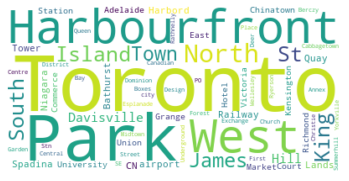

<Figure size 2160x3240 with 0 Axes>

In [63]:
stopwords = set(STOPWORDS)
stopwords = set(STOPWORDS)

# instantiate a word cloud object
neigh = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
neigh.generate(cluster4)
# display the word cloud
plt.imshow(neigh, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

In [35]:
# School ratings
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster2":df3["Neighborhood"],
                      "Cluster2":df4["Neighborhood"],
                      "Cluster4":df5["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)


In [36]:
clusters

,Cluster1,Cluster2,Cluster4
0,Lawrence Park,,
1,,,Davisville North
2,,,North Toronto West
3,,,Davisville
5,,,"Deer Park,Forest Hill SE,Rathnelly,South Hill,..."
7,,,"Cabbagetown,St. James Town"
8,,,Church and Wellesley
9,,,Harbourfront
10,,,"Ryerson,Garden District"
11,,,St. James Town


In [37]:
school_ratings=pd.DataFrame({"Neighborhood":toronto_df_coors["Neighborhood"],
                                      "Ratings":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})
WordCloud_data = school_ratings

In [38]:
school_ratings.head()

,Neighborhood,Ratings
0,"Rouge,Malvern",7
1,"Highland Creek,Rouge Hill,Port Union",9
2,"Guildwood,Morningside,West Hill",5
3,Woburn,8
4,Cedarbrae,10


In [64]:
# sort the Neighborhood by ratings
school_ratings = school_ratings.sort_values(by=['Ratings']).reset_index(drop=True)
school_ratings


,Neighborhood,Ratings
0,Glencairn,1
1,Lawrence Park,1
2,"Dorset Park,Scarborough Town Centre,Wexford He...",1
3,"Cliffcrest,Cliffside,Scarborough Village West",1
4,"Birch Cliff,Cliffside West",2
5,Davisville North,2
6,"Design Exchange,Toronto Dominion Centre",2
7,"Maryvale,Wexford",2
8,"Woodbine Gardens,Parkview Hill",2
9,"Clarks Corners,Sullivan,Tam O'Shanter",2


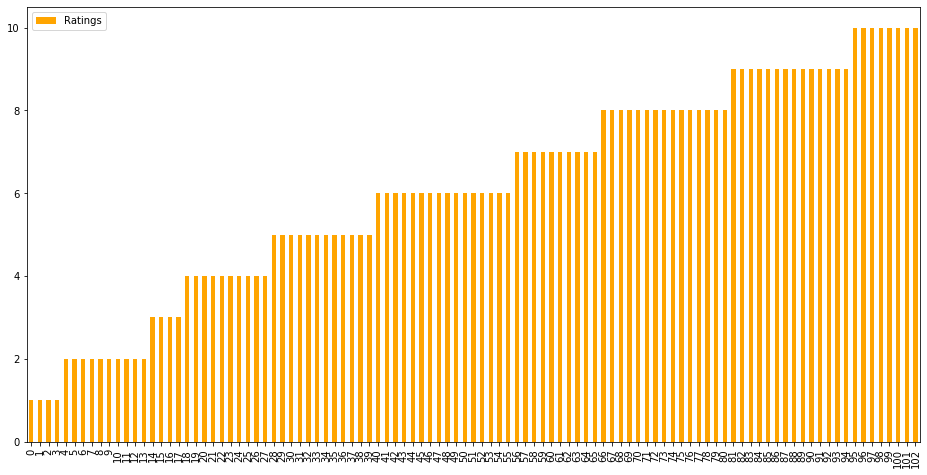

In [65]:
school_ratings.plot(kind='bar',figsize=(16,8),color='orange',alpha=1);


In [66]:
WordCloud_data = WordCloud_data.sort_values(by=['Ratings'])
WordCloud_data['Neighborhood'].to_csv('WordCloud_data.txt', sep=',', index=False)
WordCloud_data2 = open('WordCloud_data.txt', 'r').read()


/Users/nilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


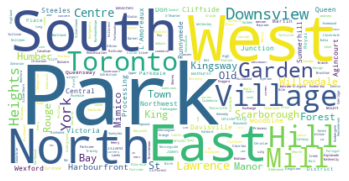

<Figure size 2160x3240 with 0 Axes>

In [67]:
stopwords = set(STOPWORDS)
stopwords = set(STOPWORDS)

# instantiate a word cloud object
neigh = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
neigh.generate(WordCloud_data2)
# display the word cloud
plt.imshow(neigh, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

<h3> Most prefered neighbourhoods </h3>

1) Park
2) West
3) North South

In [43]:
WordCloud_data_group = WordCloud_data.groupby(['Ratings'])
WordCloud_data_group.head()


,Neighborhood,Ratings
72,Glencairn,1
44,Lawrence Park,1
10,"Dorset Park,Scarborough Town Centre,Wexford He...",1
8,"Cliffcrest,Cliffside,Scarborough Village West",1
87,Business Reply Mail Processing Centre 969 Eastern,2
33,Downsview Northwest,2
15,L'Amoreaux West,2
13,"Clarks Corners,Sullivan,Tam O'Shanter",2
76,"Dovercourt Village,Dufferin",2
46,North Toronto West,3
